In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from collections import defaultdict
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, hinge_loss
import dro_model
%matplotlib inline
rc('font', family='serif')
rc('text', usetex=True)

In [2]:
def twonorm(N):
    Nc = np.int(N // 2)
    mu = 2/np.sqrt(20)
    y = np.hstack([np.ones(Nc), -np.ones(Nc)])
    X = np.vstack([np.random.normal(loc=mu, scale=1, size=[Nc, 20]),
                   np.random.normal(loc=-mu, scale=1, size=[Nc, 20])])
    return X, y

def threenorm(N):
    Nc = np.int(N // 2)
    mu = 2/np.sqrt(20)
    y = np.hstack([np.ones(Nc), -np.ones(Nc)])
    X = np.vstack([np.random.normal(loc=mu, scale=1, size=[Nc, 20]),
                   np.hstack([np.random.normal(loc=-mu, scale=1, size=[Nc, 10]),
                              np.random.normal(loc=mu, scale=1, size=[Nc, 10])])
                  ])
    return X, y

def kfold_select(param, X_train, y_train):    
    skf = StratifiedKFold(n_splits=5)
    total_loss = defaultdict(list)
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_k, X_val_k = X_train[train_index], X_train[val_index]
        y_train_k, y_val_k = y_train[train_index], y_train[val_index]
        data_k = {'x': X_train_k, 'y': y_train_k}
        optimal = dro_model.svm(param, data_k)
        for key, value in optimal.items():
            w_opt = np.array(value['w'])
            pred_decision = X_val_k.dot(w_opt)
            total_loss[key].append(hinge_loss(y_val_k, pred_decision))
    return pd.DataFrame(total_loss)[::-1].mean().idxmin()

In [3]:
epsilon = np.hstack([np.arange(1, 10) * 1e-3,
                     np.arange(1, 10) * 1e-2,
                     np.arange(1, 11) * 1e-1])
epsilon2 = np.hstack([np.arange(1, 10) * 1e-5,
                      np.arange(1, 10) * 1e-4,
                      np.arange(1, 10) * 1e-3,
                      np.arange(1, 10) * 1e-2,
                      np.arange(1, 11) * 1e-1])
PARAM = {
    'epsilon': epsilon,
    'kappa': [float('inf')],
    'pnorm': 1,
    'd': [],
    'C': []
}
PARAM2 = {
    'epsilon': epsilon2,
    'kappa': [float('inf')],
    'pnorm': 1,
    'd': [],
    'C': []
}
DIR_FIGURES = r'./figure/'
DIR_CACHE = r'./datacache/'

In [4]:
N_train = 1e3
N_array = np.hstack((np.arange(1, 10) * 10, np.arange(1, 11) * 100))
N_test = 1e5
run_count = 1000
best_epsilons = np.zeros([N_array.shape[0], run_count])
certificates = np.zeros([N_array.shape[0], epsilon.shape[0], run_count])
kfold_epsilons = np.zeros([N_array.shape[0], run_count])
risk = np.zeros(run_count)
best_case = np.zeros([epsilon2.shape[0], run_count])
worst_case = np.zeros([epsilon2.shape[0], run_count])
confidence = np.zeros([epsilon2.shape[0], run_count])
for r in range(run_count):
    if (r + 1) % 100 == 0:
        print('Iteration ', r+1)
    X_train, y_train = threenorm(N_train)
    X_test, y_test = threenorm(N_test)
    cnt_N = 0
    for N in N_array:
        Nc = np.int(N // 2)
        index = np.hstack([np.arange(Nc), np.int(N_train // 2) + np.arange(Nc)])
        X_train_i = X_train[index, :]
        y_train_i = y_train[index]
        training_data = {'x': X_train_i, 'y': y_train_i}
        optimal = dro_model.svm(PARAM, training_data)
        total_loss = {}
        cnt_eps = 0
        for key, value in optimal.items():
            w_opt = np.array(value['w'])
            J_opt = value['objective']
            pred_decision = X_test.dot(w_opt)
            total_loss[key[1]] = hinge_loss(y_test, pred_decision)
            certificates[cnt_N, cnt_eps, r] = J_opt > total_loss[key[1]]
            if N == 100 and key[1] == 1e-1:
                risk[r] = 1 - accuracy_score(
                    y_test, np.sign(pred_decision))
                worst_case[:, r] = dro_model.upper_bound_risk(
                    PARAM2, training_data, w_opt)
                best_case[:, r] = dro_model.lower_bound_risk(
                    PARAM2, training_data, w_opt)
                confidence[:, r] = np.logical_and(
                    best_case[:, r] <= risk[r],
                    worst_case[:, r] >= risk[r])
            cnt_eps += 1
        best_epsilons[cnt_N, r] = pd.Series(total_loss)[::-1].idxmin()
        kfold_epsilons[cnt_N, r] = kfold_select(PARAM, X_train_i, y_train_i)[1]
        cnt_N += 1

Iteration  100
Iteration  200
Iteration  300
Iteration  400
Iteration  500
Iteration  600
Iteration  700
Iteration  800
Iteration  900
Iteration  1000


In [26]:
condition = certificates.mean(axis=2) >= 0.95
index = np.argmax(condition[:, ::-1], axis=1)
cert_epsilons = np.array([epsilon[i] for i in index])
cert_epsilons[condition.sum(axis=1) == 0] = np.max(epsilon)

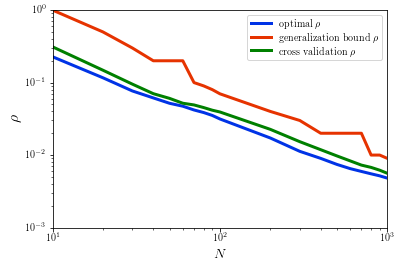

In [27]:
colors = [(0, 0.2, 0.9), (0.9, 0.2, 0), (0, 0.5, 0)]
line_width = 3
ts = stats.t.ppf(0.99, run_count-1)
fig, ax = plt.subplots()
ax.plot(N_array, best_epsilons.mean(axis=1),
         color=colors[0], linewidth=line_width)
condition = certificates.mean(axis=2) >= 0.95
index = np.argmax(condition[:, ::-1], axis=1)
cert_epsilons = np.array([epsilon[i] for i in index])
cert_epsilons[condition.sum(axis=1) == 0] = np.max(epsilon)
ax.plot(N_array, cert_epsilons,
         color=colors[1], linewidth=line_width)
ax.plot(N_array, kfold_epsilons.mean(axis=1),
         color=colors[2], linewidth=line_width)
ax.legend([r'optimal $\rho$',
           r'generalization bound $\rho$',
           r'cross validation $\rho$'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$', fontsize=14)
ax.set_ylabel(r'$\rho$', fontsize=16)
ax.set_ylim(1e-3, 1e0)
ax.set_xlim(1e1, 1e3)
fig.savefig(DIR_FIGURES + 'best_eps.eps', format='eps', dpi=1000)
fig.set_facecolor('white')

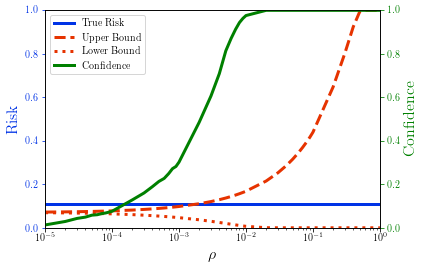

In [28]:
colors = [(0, 0.2, 0.9), (0.9, 0.2, 0), (0.9, 0.2, 0)]
fig, ax1 = plt.subplots()
ax1.set_prop_cycle('color', colors)
ax1.plot(epsilon2, risk.mean() * np.ones(epsilon2.shape),
         epsilon2, worst_case.mean(axis=1), '--',
         epsilon2, best_case.mean(axis=1), ':',
         linewidth=line_width)
ax1.plot(np.nan, color=(0, 0.5, 0), linewidth=line_width)

ax1.set_xscale('log')
ax1.set_xlabel(r'$\rho$', fontsize=16)
ax1.set_ylabel('Risk', fontsize=16, color=colors[0])
ax1.tick_params('y', colors=colors[0])
ax1.set_xlim(1e-5, 1e0)
ax1.set_ylim(0, 1.0)
plt.legend(['True Risk', 'Upper Bound', 'Lower Bound', 'Confidence'])
ax2 = ax1.twinx()
ax2.plot(epsilon2, confidence.mean(axis=1),
         color=(0, 0.5, 0), linewidth=line_width)
ax2.set_ylabel('Confidence', fontsize=16, color=(0, 0.5, 0))
ax2.tick_params('y', colors=(0, 0.5, 0))
ax2.set_xlim(1e-5, 1e0)
ax2.set_ylim(0, 1.0)
fig.savefig(DIR_FIGURES + 'risk.eps', format='eps', dpi=1000)
fig.set_facecolor('white')

In [34]:
ind = np.argmax(confidence.mean(axis=1) >= 0.95)
print(epsilon2[ind], confidence.mean(axis=1)[ind], risk.mean(),
      worst_case.mean(axis=1)[ind], best_case.mean(axis=1)[ind])

0.009 0.963 0.11023609 0.162558572591 0.00845772676167


In [ ]:
N_train = 1e4
N_array2 = np.array([10, 100, 1000, 10000])
N_test = 1e5
run_count = 1000
norms_w = np.zeros([N_array2.shape[0], epsilon2.shape[0], run_count])
for r in range(run_count):
    if (r + 1) % 100 == 0:
        print('Iteration ', r+1)
    X_train, y_train = threenorm(N_train)
    X_test, y_test = threenorm(N_test)
    cnt_N = 0
    for N in N_array2:
        Nc = np.int(N // 2)
        index = np.hstack([np.arange(Nc), np.int(N_train // 2) + np.arange(Nc)])
        X_train_i = X_train[index, :]
        y_train_i = y_train[index]
        training_data = {'x': X_train_i, 'y': y_train_i}
        optimal = dro_model.svm(PARAM2, training_data)
        total_loss = {}
        cnt_eps = 0
        for key, value in optimal.items():
            w_opt = np.array(value['w'])
            norms_w[cnt_N, cnt_eps, r] = np.linalg.norm(w_opt, 1)
            cnt_eps += 1
        cnt_N += 1

In [ ]:
per_max_norm = np.percentile(norms_w, 95, axis=2).T
per_min_norm = np.percentile(norms_w, 5, axis=2).T
fig, ax = plt.subplots()
colors = [(0, 0.2, 0.9), (0.9, 0.2, 0), (0, 0.5, 0), (0.5, 0.2, 0.5)]
plt.rcParams['text.latex.preamble']=[r'\usepackage{bm}',
                                     r'\usepackage{amsfonts}']
ax.set_prop_cycle('color', colors)
for index, N in enumerate(N_array2):
    print(index)
    ax.fill_between(epsilon2[::-1], per_max_norm[:, index],
                    per_min_norm[:, index], alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rho$', fontsize=16)
ax.set_ylabel(r'$\Vert {\bm{w}} \Vert_{*}$', fontsize=16)
ax.set_xlim(1e-5, 1e0)
ax.legend([r'$N=10$', r'$N=100$', r'$N=1000$', r'$N=10000$'])
fig.savefig(DIR_FIGURES + 'quantile.pdf', format='pdf', dpi=1000)
fig.set_facecolor('white')

In [ ]:
max_norm = np.max(norms_w, axis=2).T
min_norm = np.min(norms_w, axis=2).T
max_norm[max_norm == 0] = np.nan
min_norm[min_norm == 0] = np.nan
colors = [(0, 0.2, 0.9), (0.9, 0.2, 0), (0, 0.5, 0)]
plt.rcParams['text.latex.preamble']=[r'\usepackage{bm}',
                                     r'\usepackage{amsfonts}']

fig, ax = plt.subplots()
ax.set_prop_cycle('color', colors)
ax.plot(epsilon2[::-1], max_norm[:, 1::], linewidth=3)
ax.plot(epsilon2[::-1], min_norm[:, 1::], ':', linewidth=3)
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$', fontsize=16)
ax.set_ylabel(r'$\Vert {\bm{w}} \Vert_{*}$', fontsize=16)
ax.set_xlim(1e-5, 1e0)

lines = ax.get_lines()
title = r'$\max \Vert {\bm{w}} \Vert_{*}$' + \
        r'$\qquad \qquad \qquad$' + \
        r'$\min \Vert {\bm{w}} \Vert_{*}$'
plt.legend([lines[i] for i in range(6)],
           [r'$N=100$', r'$N=1000$', r'$N=10000$',
            r'$N=100$', r'$N=1000$', r'$N=10000$'],
           title=title,
           ncol=2, loc=1)
fig.savefig(DIR_FIGURES + 'up_low.eps', format='eps', dpi=1000)
fig.set_facecolor('white')

In [ ]:
max_norm2 = np.percentile(norms_w, 95, axis=2).T
min_norm2 = np.percentile(norms_w, 5, axis=2).T
max_norm2[max_norm2 == 0] = np.nan
min_norm2[min_norm2 == 0] = np.nan
fig, ax = plt.subplots()
ax.set_prop_cycle('color', colors)
ax.plot(epsilon2[::-1], max_norm[:, 1::] / min_norm[:, 1::],
        ':', linewidth =3)
ax.plot(epsilon2[::-1], max_norm2[:, 1::] / min_norm2[:, 1::], linewidth =3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rho$', fontsize=16)
ylabel = r'$\mathrm{VaR}_{1-\alpha}(\Vert {\bm{w}} \Vert_{*}) / $' + \
         r'$\mathrm{VaR}_{\alpha}(\Vert {\bm{w}} \Vert_{*})$'
ax.set_ylabel(ylabel, fontsize=16)
ax.set_xlim(1e-5, 1e0)
ax.set_ylim(0, 100)

lines = ax.get_lines()
title = r'$\alpha = 0$' + \
        r'$\qquad \quad \qquad$' + \
        r'$\alpha = 0.05$'
plt.legend([lines[i] for i in range(6)],
           [r'$N=10^2$', r'$N=10^3$', r'$N=10^4$',
            r'$N=10^2$', r'$N=10^3$', r'$N=10^4$'],
           title=title,
           ncol=2, loc=1)
fig.savefig(DIR_FIGURES + 'ratio.pdf', format='pdf', dpi=1000)
fig.set_facecolor('white')

In [29]:
np.savetxt(DIR_CACHE + 'best_eps.csv', best_epsilons, delimiter=',')
np.savetxt(DIR_CACHE + 'kfold_eps.csv', kfold_epsilons, delimiter=',')
np.save(DIR_CACHE + 'certificates.npy', certificates)
# np.save(DIR_CACHE + 'norms_w.npy', norms_w)
np.savetxt(DIR_CACHE + 'risk.csv', risk, delimiter=',')
np.savetxt(DIR_CACHE + 'best_case.csv', best_case, delimiter=',')
np.savetxt(DIR_CACHE + 'worst_case.csv', worst_case, delimiter=',')
np.savetxt(DIR_CACHE + 'confidence.csv', confidence, delimiter=',')
# best_epsilons = np.loadtxt(DIR_CACHE + 'best_eps.csv', delimiter=',')
# kfold_epsilons = np.loadtxt(DIR_CACHE + 'kfold_eps.csv', delimiter=',')
# certificates = np.load(DIR_CACHE + 'certificates.npy')
# norms_w = np.load(DIR_CACHE + 'norms_w.npy')
# risk = np.loadtxt(DIR_CACHE + 'risk.csv', delimiter=',')
# best_case = np.loadtxt(DIR_CACHE + 'best_case.csv', delimiter=',')
# worst_case = np.loadtxt(DIR_CACHE + 'worst_case.csv', delimiter=',')
# confidence = np.loadtxt(DIR_CACHE + 'confidence.csv', delimiter=',')